<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

Step 1.1

In [1]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
from datetime import datetime
import utils
from utils import scale
from utils import calculate_band_indices
from utils import load_data
from utils import patchwise_glcm_feature
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt
import joblib
from shapely.geometry import box
import skimage.feature
from skimage.feature import graycomatrix, graycoprops
from skimage import data
from skimage.util import view_as_windows
import dask.array as da

In [2]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"
# Enter your site name
site = "utanglang"
# Date
date = datetime.now()
date = date.strftime("%d-%m-%Y")

version = initials+'-'+site+'-'+date

print(version)

nm-utanglang-04-07-2025


Define catalogue

In [3]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [4]:
## Use tdata bounds

gdf = gpd.read_file("testing-data/utanglang_postcard.geojson")
gdf = gdf.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
bbox = [min_lon, min_lat, max_lon, max_lat]

In [5]:
## Use bounding box

# min_lon = 160.08855
# min_lat = -9.12915
# max_lon = 160.17137
# max_lat = -9.08003

# bbox = [min_lon, min_lat, max_lon, max_lat]

In [6]:
datetime="2024"
items = list(client.search(collections=["dep_s2_geomad"], datetime=datetime, bbox=bbox).items())

In [7]:
from pystac import Collection

In [8]:
collection = Collection.from_file("https://stac.digitalearthpacific.org/collections/dep_s2_geomad")

In [9]:
data = load(
        items,
        measurements=[
            "nir", "red", "blue", "green", "emad", "smad", 
            "bcmad", "count", "green", "nir08", 
            "nir09", "swir16", "swir22", "coastal",
            "rededge1", "rededge2", "rededge3", 
        ],
        bbox=bbox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )

In [10]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
configure_s3_access(cloud_defaults=True, requester_pays=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40397 instead
  warnings.warn(


In [11]:
scaled = (data.where(data != 0) * 0.0001).clip(0, 1)

In [12]:
mndwi = (scaled["green"]-scaled["swir16"])/(scaled["green"]+scaled["swir16"])
## Moderate land mask
# mndwi_land_mask = mndwi > 0
mndwi_land_mask = mndwi > -1.5
clipped_ds = scaled.where(mndwi_land_mask)

In [13]:
ndti = (clipped_ds["red"]-clipped_ds["green"])/(clipped_ds["red"]+clipped_ds["green"])
ndti_mask = ndti < 0.2
clipped_ds = clipped_ds.where(ndti_mask)

In [14]:
nir = clipped_ds['nir']

# Moderate land mask
# nir_mask = nir < 0.085

# Conservative land mask
nir_mask = nir < 0.8
clipped_ds = clipped_ds.where(nir_mask)

In [15]:
# Incorporate other band ratios and indices
cai = (clipped_ds["coastal"]-clipped_ds["blue"])/( clipped_ds["coastal"]+ clipped_ds["blue"]) #coastal aerosol index
ndvi = (clipped_ds["nir"]-clipped_ds["red"])/( clipped_ds["nir"]+ clipped_ds["red"]) #vegetation index (NDVI)
evi = ((2.5*clipped_ds["nir"]-clipped_ds["red"])/(clipped_ds["nir"]+(6*clipped_ds["red"])-(7.5*clipped_ds["blue"])+1)) # enhanced vegetation index
savi = (clipped_ds["nir"]-clipped_ds["red"])/(clipped_ds["nir"]+clipped_ds["red"]) # soil adjusted vegetation index
ndwi = (clipped_ds["green"]-clipped_ds["nir"])/(clipped_ds["green"]+clipped_ds["nir"]+0.428)*(1+0.428) #water index (NDWI)
b_g = (clipped_ds["blue"])/(clipped_ds["green"]) #blue to green ratio
b_r = (clipped_ds["blue"])/(clipped_ds["red"]) #blue to red ratio
mci = (clipped_ds["nir"])/(clipped_ds["rededge1"]) # max chlorophlyll index (MCI)
ndci = (clipped_ds["rededge1"]-clipped_ds["red"])/(clipped_ds["rededge1"]+clipped_ds["red"]) # normalised difference chlorophyll index (NDCI)


In [16]:
clipped_ds['cai'] = cai
clipped_ds['ndvi'] = ndvi
clipped_ds['evi'] = evi
clipped_ds['savi'] = savi
clipped_ds['ndwi'] = ndwi
clipped_ds['mndwi'] = mndwi
clipped_ds['ndti'] = ndti
clipped_ds['b_g'] = b_g
clipped_ds['b_r'] = b_r
clipped_ds['mci'] = mci
clipped_ds['ndci'] = ndci

# clipped_ds

In [17]:
# Natural log of blue/green
clipped_ds["ln_bg"] = np.log(clipped_ds.blue / clipped_ds.green)
bg = clipped_ds["ln_bg"]
# conservative deep sea mask
mask_bg = bg < 0.0000001

In [18]:
# all_masks = (mndwi_land_mask+ndti_mask+nir_mask+mask_bg)
all_masks = (mndwi_land_mask+ndti_mask+nir_mask)

### GLCM texture analysis

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [19]:
texture_image = clipped_ds.to_dataarray()

In [20]:
texture_image = texture_image.where(all_masks)

In [21]:
image_blue = clipped_ds['blue'].values  # Convert to numpy array for GLCM

In [22]:
# Remove NaNs (optional, depending on your data)
image_blue = np.nan_to_num(image_blue, nan=0)

# Normalize to 0–255 and convert to uint8
image_uint8 = ((image_blue - image_blue.min()) / (image_blue.max() - image_blue.min()) * 255).astype('uint8')

image_uint8 = image_uint8[0, :, :]  # Use the first band/slice
print("Selected image shape:", image_uint8.shape)

Selected image shape: (147, 62)


In [23]:
postcard_crs = clipped_ds.rio.crs
postcard_transform = clipped_ds.rio.transform()

In [24]:
def normalize_image(img):
    image_blue_min = np.nanmin(image_blue)
    image_blue_max = np.nanmax(image_blue)
    if image_blue_max == image_blue_min:
        # All pixels are the same, return a zero array
        return np.zeros_like(image_blue, dtype='uint8')
    arr = (image_blue - image_blue_min) / (image_blue_max - image_blue_min)
    arr = np.clip(arr, 0, 1)  # ensure no negatives or >1 due to rounding
    arr = (arr * 255).astype('uint8')
    return arr


In [25]:
# Preprocess
image_uint8 = np.nan_to_num(image_uint8, nan=0)
image_uint8 = np.squeeze(image_uint8)
image_uint8 = np.ascontiguousarray(image_uint8)
image_uint8 = image_uint8.astype('uint8')
print("Final image_uint8 shape:", image_uint8.shape)
print("Final image_uint8 dtype:", image_uint8.dtype)



Final image_uint8 shape: (147, 62)
Final image_uint8 dtype: uint8


In [26]:
# Remove all dimensions of size 1
image2d = np.squeeze(image_blue)
# OR, if you want to be explicit:
image2d = image_blue[0, :, :]  # Select first band
print(image2d.shape)  # Should be (147, 62)

(147, 62)


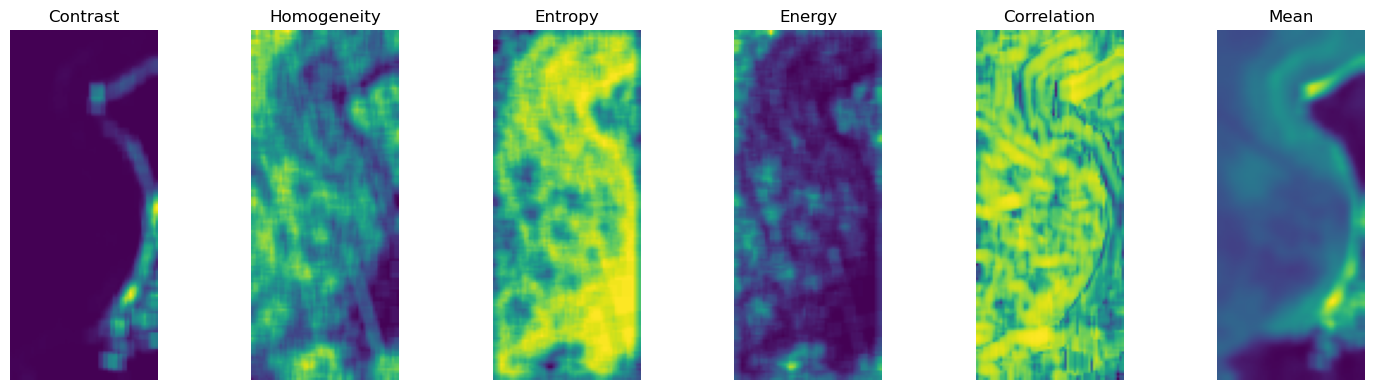

In [27]:
features = patchwise_glcm_feature(
    image_uint8, 
    window_size=7, 
    levels=256
)

# Visualize the features
plt.figure(figsize=(15, 4))
for idx, (name, fmap) in enumerate(features.items()):
    plt.subplot(1, len(features), idx+1)
    plt.imshow(fmap, cmap='viridis')
    plt.title(name.capitalize())
    plt.axis('off')
plt.tight_layout()
plt.show()

In [28]:
## Export texture tifs

# for name, arr in features.items():
#     # Ensure array is 2D and float32 for GeoTIFF
#     arr = np.asarray(arr, dtype='float32')
#     if arr.ndim == 3:
#         arr = np.squeeze(arr)
#     tif_name = f"glcm_{name}.tif"

#     with rio.open(
#         tif_name,
#         'w',
#         driver='GTiff',
#         height=arr.shape[0],
#         width=arr.shape[1],
#         count=1,
#         dtype=arr.dtype,
#         crs=postcard_crs,
#         transform=postcard_transform,
#         nodata=np.nan
#     ) as dst:
#         dst.write(arr, 1)

#     print("/glcm/"f"Wrote {tif_name}")

In [29]:
image2d

array([[0.0638    , 0.0656    , 0.0649    , ..., 0.08769999, 0.0862    ,
        0.0867    ],
       [0.0642    , 0.06439999, 0.0636    , ..., 0.09      , 0.0883    ,
        0.0853    ],
       [0.0636    , 0.063     , 0.0624    , ..., 0.0885    , 0.0879    ,
        0.0859    ],
       ...,
       [0.0624    , 0.0658    , 0.0717    , ..., 0.0332    , 0.0302    ,
        0.0289    ],
       [0.0646    , 0.06879999, 0.0703    , ..., 0.0316    , 0.0314    ,
        0.0301    ],
       [0.064     , 0.0691    , 0.0735    , ..., 0.0303    , 0.0306    ,
        0.0335    ]], dtype=float32)

In [30]:
clipped_ds=clipped_ds.squeeze()

In [31]:
for name, arr in features.items():
    clipped_ds[f'glcm_{name}'] = xr.DataArray(
        arr,
        dims=('y', 'x'),
        coords={'y': clipped_ds['y'], 'x': clipped_ds['x']},
        name=f'glcm_{name}'
    )

In [32]:
clipped_ds

<xarray.Dataset> Size: 1MB
Dimensions:           (y: 147, x: 62)
Coordinates:
  * y                 (y) float64 1kB -1.957e+06 -1.957e+06 ... -1.958e+06
  * x                 (x) float64 496B 2.04e+06 2.04e+06 ... 2.04e+06 2.04e+06
    spatial_ref       int32 4B 3832
    time              datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir               (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    red               (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    blue              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    green             (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    emad              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    smad              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    ...                ...
    glcm_contrast     (y, x) float32 36kB 1.0 0.881 0.7143 ... 4.738 2.738 2.476
    glcm_homogeneity  (y, x) float32 36kB 0.6143 0.6452 0.7286 ... 0.5167 0.5048
    glcm_entropy      (y, x) float32 36kB 3.606 3.553 3.473 ... 3.802 3.744
    glcm_energy       (y, x) float32 36kB 0.3068 0.3113 0.3388 ... 0.2746 0.2857
    glcm_correlation  (y, x) float32 36kB 0.524 0.5904 0.6627 ... 0.07498 0.1236
    glcm_mean         (y, x) float32 36kB 36.74 36.68 36.48 ... 5.321 5.333

### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [33]:
# Define training data
gdf = gpd.read_file("testing-data/utanglang_postcard.geojson")
gdf = gdf.to_crs("EPSG:4326")
# gdf.explore(column="cc_id", legend=True)
clipped_ds

<xarray.Dataset> Size: 1MB
Dimensions:           (y: 147, x: 62)
Coordinates:
  * y                 (y) float64 1kB -1.957e+06 -1.957e+06 ... -1.958e+06
  * x                 (x) float64 496B 2.04e+06 2.04e+06 ... 2.04e+06 2.04e+06
    spatial_ref       int32 4B 3832
    time              datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir               (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    red               (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    blue              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    green             (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    emad              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    smad              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    ...                ...
    glcm_contrast     (y, x) float32 36kB 1.0 0.881 0.7143 ... 4.738 2.738 2.476
    glcm_homogeneity  (y, x) float32 36kB 0.6143 0.6452 0.7286 ... 0.5167 0.5048
    glcm_entropy      (y, x) float32 36kB 3.606 3.553 3.473 ... 3.802 3.744
    glcm_energy       (y, x) float32 36kB 0.3068 0.3113 0.3388 ... 0.2746 0.2857
    glcm_correlation  (y, x) float32 36kB 0.524 0.5904 0.6627 ... 0.07498 0.1236
    glcm_mean         (y, x) float32 36kB 36.74 36.68 36.48 ... 5.321 5.333

In [34]:
postcard = clipped_ds#.where(all_masks)
# postcard =clipped_ds.to_array(dim="band")
# First transform the training points to the same CRS as the data
training = gdf.to_crs(postcard.odc.geobox.crs)

In [35]:
print(training.columns)
training=training.drop(columns=['date', 'uuid'])

Index(['fid', 'observed', 'cc_id', 'date', 'uuid', 'geometry'], dtype='object')


In [36]:
training

,fid,observed,cc_id,geometry
0,1,None,6,POINT (2039841.422 -1957298.334)
1,2,None,6,POINT (2039813.293 -1957150.554)
2,3,None,6,POINT (2039815.739 -1957070.295)
3,4,None,6,POINT (2039878.111 -1957020.611)
4,5,None,6,POINT (2039938.037 -1956942.901)
...,...,...,...,...
156,157,coral,None,POINT (2039886.796 -1957358.441)
157,158,coral,None,POINT (2039949.133 -1957399.288)
158,159,coral,None,POINT (2040001.415 -1957431.756)
159,160,coral,None,POINT (2039931.035 -1957338.541)


In [37]:
training_da = training.assign(x=training.geometry.x, y=training.geometry.y).to_xarray()

In [38]:
training_values = (
    postcard.sel(training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
training_values

,nir,red,blue,green,emad,smad,bcmad,count,nir08,nir09,...,b_r,mci,ndci,ln_bg,glcm_contrast,glcm_homogeneity,glcm_entropy,glcm_energy,glcm_correlation,glcm_mean
index,,,,,,,,,,,,,,,,,,,,,
0,0.0239,0.0302,0.0772,0.0705,0.086266,0.000006,0.000037,0.0055,0.0263,0.0324,...,2.556291,0.796667,-0.003322,0.090787,13.642858,0.252113,5.975418,0.132566,0.670317,50.107143
1,0.0271,0.0334,0.0799,0.0742,0.083707,0.000005,0.000033,0.0057,0.0284,0.0339,...,2.392215,0.833846,-0.013657,0.074012,6.166667,0.305548,5.597924,0.155219,0.817033,54.630951
2,0.0289,0.0347,0.0830,0.0774,0.087613,0.000005,0.000034,0.0061,0.0303,0.0411,...,2.391931,0.840116,-0.004342,0.069854,7.761905,0.361093,5.645543,0.153382,0.768348,52.642857
3,0.0254,0.0338,0.0764,0.0739,0.085507,0.000004,0.000027,0.0059,0.0276,0.0403,...,2.260355,0.751479,0.000000,0.033270,4.880952,0.471458,5.391852,0.164096,0.700600,51.559525
4,0.0249,0.0314,0.0727,0.0671,0.072944,0.000005,0.000031,0.0060,0.0258,0.0352,...,2.315287,0.792994,0.000000,0.080157,8.380953,0.358227,5.892317,0.135735,0.671101,50.738094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,0.0274,0.0328,0.0786,0.0719,0.088091,0.000006,0.000037,0.0054,0.0273,0.0348,...,2.396341,0.808260,0.016492,0.089096,10.595238,0.366406,5.797079,0.141862,0.887878,52.035713
157,0.0222,0.0355,0.0803,0.0854,0.080959,0.000005,0.000032,0.0054,0.0255,0.0329,...,2.261972,0.487912,0.123457,-0.061577,10.690476,0.409544,5.568278,0.172516,0.835917,50.916668
158,0.0224,0.0390,0.0738,0.0796,0.070275,0.000004,0.000029,0.0054,0.0232,0.0314,...,1.892308,0.491228,0.078014,-0.075655,9.666667,0.372384,5.797079,0.143846,0.769879,49.857143


In [39]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)
# Drop rows where there was no data available
training_array = training_array.dropna()
# Preview our resulting training array
training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,b_r,mci,ndci,ln_bg,glcm_contrast,glcm_homogeneity,glcm_entropy,glcm_energy,glcm_correlation,glcm_mean
0,6,0.0239,0.0302,0.0772,0.0705,0.086266,0.000006,0.000037,0.0055,0.0263,...,2.556291,0.796667,-0.003322,0.090787,13.642858,0.252113,5.975418,0.132566,0.670317,50.107143
1,6,0.0271,0.0334,0.0799,0.0742,0.083707,0.000005,0.000033,0.0057,0.0284,...,2.392215,0.833846,-0.013657,0.074012,6.166667,0.305548,5.597924,0.155219,0.817033,54.630951
2,6,0.0289,0.0347,0.0830,0.0774,0.087613,0.000005,0.000034,0.0061,0.0303,...,2.391931,0.840116,-0.004342,0.069854,7.761905,0.361093,5.645543,0.153382,0.768348,52.642857
3,6,0.0254,0.0338,0.0764,0.0739,0.085507,0.000004,0.000027,0.0059,0.0276,...,2.260355,0.751479,0.000000,0.033270,4.880952,0.471458,5.391852,0.164096,0.700600,51.559525
4,6,0.0249,0.0314,0.0727,0.0671,0.072944,0.000005,0.000031,0.0060,0.0258,...,2.315287,0.792994,0.000000,0.080157,8.380953,0.358227,5.892317,0.135735,0.671101,50.738094


### Notebook 2 - Train Random Forest Machine Learning (ML) Model

Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model

Step 2.1. Concatenating all postcard dataframes

In [40]:
postcard_df = training_array
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time', 'cai', 'ndvi',
       'evi', 'savi', 'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci',
       'ln_bg', 'glcm_contrast', 'glcm_homogeneity', 'glcm_entropy',
       'glcm_energy', 'glcm_correlation', 'glcm_mean'],
      dtype='object')

In [41]:
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time', 'cai', 'ndvi',
       'evi', 'savi', 'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci',
       'ln_bg', 'glcm_contrast', 'glcm_homogeneity', 'glcm_entropy',
       'glcm_energy', 'glcm_correlation', 'glcm_mean'],
      dtype='object')

In [42]:
# postcard_df.columns
# postcard_df = postcard_df.drop(columns=["spatial_ref", "time", "field_1", "y", "x"])
# postcard_df = postcard_df.drop(columns=["field_1"])
postcard_df = postcard_df.drop(columns=["y", "x", "spatial_ref", "time"])
# postcard_df = postcard_df.drop(columns=["time"])
postcard_df

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,b_r,mci,ndci,ln_bg,glcm_contrast,glcm_homogeneity,glcm_entropy,glcm_energy,glcm_correlation,glcm_mean
0,6,0.0239,0.0302,0.0772,0.0705,0.086266,0.000006,0.000037,0.0055,0.0263,...,2.556291,0.796667,-0.003322,0.090787,13.642858,0.252113,5.975418,0.132566,0.670317,50.107143
1,6,0.0271,0.0334,0.0799,0.0742,0.083707,0.000005,0.000033,0.0057,0.0284,...,2.392215,0.833846,-0.013657,0.074012,6.166667,0.305548,5.597924,0.155219,0.817033,54.630951
2,6,0.0289,0.0347,0.0830,0.0774,0.087613,0.000005,0.000034,0.0061,0.0303,...,2.391931,0.840116,-0.004342,0.069854,7.761905,0.361093,5.645543,0.153382,0.768348,52.642857
3,6,0.0254,0.0338,0.0764,0.0739,0.085507,0.000004,0.000027,0.0059,0.0276,...,2.260355,0.751479,0.000000,0.033270,4.880952,0.471458,5.391852,0.164096,0.700600,51.559525
4,6,0.0249,0.0314,0.0727,0.0671,0.072944,0.000005,0.000031,0.0060,0.0258,...,2.315287,0.792994,0.000000,0.080157,8.380953,0.358227,5.892317,0.135735,0.671101,50.738094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2,0.0236,0.0432,0.0666,0.0754,0.064290,0.000004,0.000025,0.0052,0.0202,...,1.541667,0.488613,0.055738,-0.124103,14.380953,0.337211,5.761132,0.147734,0.655635,39.690475
117,2,0.0225,0.0417,0.0660,0.0741,0.062158,0.000004,0.000026,0.0051,0.0207,...,1.582734,0.398936,0.149847,-0.115761,14.523809,0.341055,5.969582,0.133631,0.787156,37.976189
118,2,0.0253,0.0448,0.0664,0.0737,0.068001,0.000004,0.000026,0.0052,0.0210,...,1.482143,0.479167,0.081967,-0.104306,10.738095,0.335260,5.761132,0.147734,0.658219,40.369049
119,2,0.0217,0.0334,0.0637,0.0647,0.067852,0.000005,0.000031,0.0052,0.0228,...,1.907186,0.597796,0.041607,-0.015577,17.452381,0.231235,5.963746,0.130410,0.643604,35.773811


In [43]:
len(postcard_df.columns)

35

In [44]:
postcard_df.to_csv("training-data/35_params_tdata_04072025.csv")

In [45]:
joined_df = pd.read_csv("training-data/35_params_tdata_04072025.csv")
joined_df.columns

Index(['Unnamed: 0', 'cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad',
       'bcmad', 'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal',
       'rededge1', 'rededge2', 'rededge3', 'cai', 'ndvi', 'evi', 'savi',
       'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg',
       'glcm_contrast', 'glcm_homogeneity', 'glcm_entropy', 'glcm_energy',
       'glcm_correlation', 'glcm_mean'],
      dtype='object')

In [46]:
joined_df = joined_df.drop(columns=["Unnamed: 0"])
joined_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'mndwi',
       'ndti', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'glcm_contrast',
       'glcm_homogeneity', 'glcm_entropy', 'glcm_energy', 'glcm_correlation',
       'glcm_mean'],
      dtype='object')

In [47]:
correlation_matrix = joined_df.corr()

# Display the matrix
print(correlation_matrix)

                     cc_id       nir       red      blue     green      emad  \
cc_id             1.000000 -0.116785 -0.184195  0.009746 -0.126394  0.029686   
nir              -0.116785  1.000000  0.880964  0.731891  0.711295  0.730207   
red              -0.184195  0.880964  1.000000  0.917653  0.940327  0.709422   
blue              0.009746  0.731891  0.917653  1.000000  0.968689  0.627107   
green            -0.126394  0.711295  0.940327  0.968689  1.000000  0.647112   
emad              0.029686  0.730207  0.709422  0.627107  0.647112  1.000000   
smad              0.193485 -0.686854 -0.708196 -0.587775 -0.673408 -0.458027   
bcmad             0.308515 -0.705811 -0.711636 -0.536396 -0.636180 -0.403405   
count             0.307756 -0.234076 -0.438104 -0.418498 -0.546105 -0.481059   
nir08            -0.097099  0.928343  0.742602  0.584334  0.567086  0.687034   
nir09            -0.131547  0.755319  0.718849  0.601445  0.635092  0.696530   
swir16           -0.070936  0.936464  0.

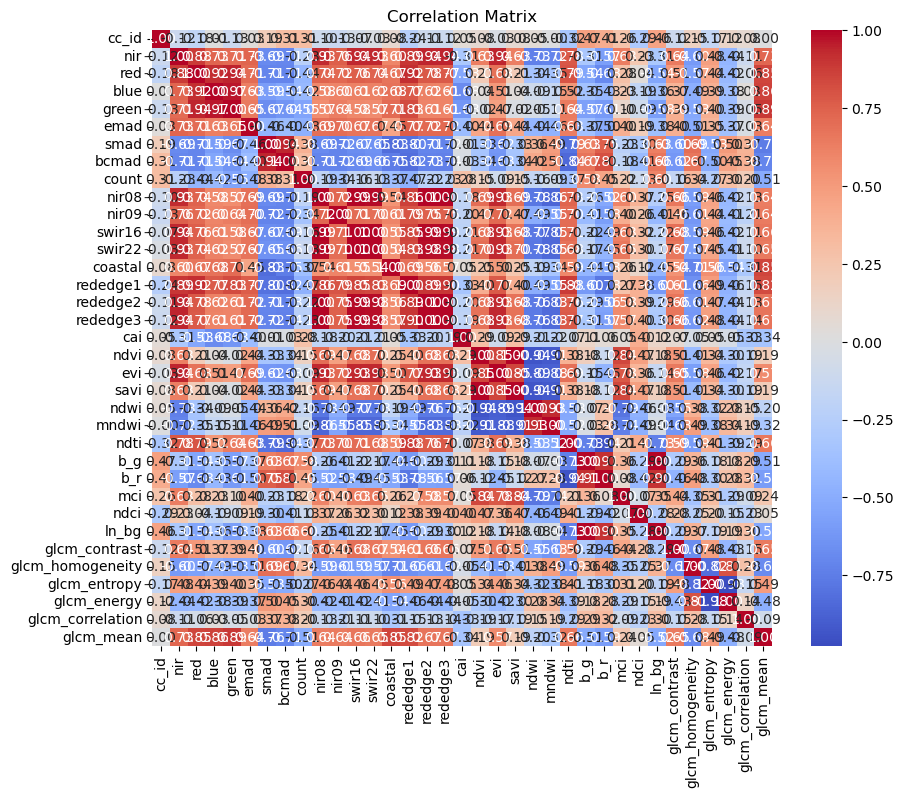

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [49]:
threshold = 0.8
high_corr = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]
print(high_corr)

                  cc_id       nir       red      blue     green  emad  \
cc_id               NaN       NaN       NaN       NaN       NaN   NaN   
nir                 NaN       NaN  0.880964       NaN       NaN   NaN   
red                 NaN  0.880964       NaN  0.917653  0.940327   NaN   
blue                NaN       NaN  0.917653       NaN  0.968689   NaN   
green               NaN       NaN  0.940327  0.968689       NaN   NaN   
emad                NaN       NaN       NaN       NaN       NaN   NaN   
smad                NaN       NaN       NaN       NaN       NaN   NaN   
bcmad               NaN       NaN       NaN       NaN       NaN   NaN   
count               NaN       NaN       NaN       NaN       NaN   NaN   
nir08               NaN  0.928343       NaN       NaN       NaN   NaN   
nir09               NaN       NaN       NaN       NaN       NaN   NaN   
swir16              NaN  0.936464       NaN       NaN       NaN   NaN   
swir22              NaN  0.933246       NaN       N

In [50]:
high_corr.to_csv(f"{version}_high_correlation_matrix.csv")

Step 2.2. Train the ML model

In [51]:
# The classes are the first column
classes = np.array(postcard_df)[:, 0]

# The observation data is everything after the second column
observations = np.array(postcard_df)[:, 1:]

# Create a model...
classifier = RandomForestClassifier()

# ...and fit it to the data
model = classifier.fit(observations, classes)

In [52]:
# Dynamically create the filename with f-string
file_path = f"models/{version}-test.model"

# Save the model
joblib.dump(model, file_path)

['models/nm-utanglang-04-07-2025-test.model']

In [53]:
postcard_params = postcard_df.columns[1:]
print(postcard_params)

Index(['nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad', 'count',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2',
       'rededge3', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'mndwi', 'ndti',
       'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'glcm_contrast',
       'glcm_homogeneity', 'glcm_entropy', 'glcm_energy', 'glcm_correlation',
       'glcm_mean'],
      dtype='object')


In [54]:
importances = classifier.feature_importances_

# Create the DataFrame
data = {
    'param': postcard_params,  # Use the list directly
    'importance': importances,  # Use the list directly
}
importance_df = pd.DataFrame(data)

importance_df["%"] = (importance_df["importance"]*100)

sorted_df = importance_df.sort_values(by='importance', ascending=False)
sorted_df.to_csv(f"{version}importance_df.csv")

In [55]:
# sorted_df
# sorted_df.to_csv('sorted.csv', index=False)

In [56]:
postcard


<xarray.Dataset> Size: 1MB
Dimensions:           (y: 147, x: 62)
Coordinates:
  * y                 (y) float64 1kB -1.957e+06 -1.957e+06 ... -1.958e+06
  * x                 (x) float64 496B 2.04e+06 2.04e+06 ... 2.04e+06 2.04e+06
    spatial_ref       int32 4B 3832
    time              datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir               (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    red               (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    blue              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    green             (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    emad              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    smad              (y, x) float32 36kB dask.array<chunksize=(147, 62), meta=np.ndarray>
    ...                ...
    glcm_contrast     (y, x) float32 36kB 1.0 0.881 0.7143 ... 4.738 2.738 2.476
    glcm_homogeneity  (y, x) float32 36kB 0.6143 0.6452 0.7286 ... 0.5167 0.5048
    glcm_entropy      (y, x) float32 36kB 3.606 3.553 3.473 ... 3.802 3.744
    glcm_energy       (y, x) float32 36kB 0.3068 0.3113 0.3388 ... 0.2746 0.2857
    glcm_correlation  (y, x) float32 36kB 0.524 0.5904 0.6627 ... 0.07498 0.1236
    glcm_mean         (y, x) float32 36kB 36.74 36.68 36.48 ... 5.321 5.333

In [57]:
# Convert to a stacked array of observations
# stacked_arrays = stacked_arrays.squeeze()
stacked_arrays = postcard.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays = stacked_arrays.to_dataarray()

In [58]:
stacked_arrays

<xarray.DataArray (variable: 34, y: 147, x: 62)> Size: 1MB
dask.array<stack, shape=(34, 147, 62), dtype=float32, chunksize=(1, 147, 62), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1kB -1.957e+06 -1.957e+06 ... -1.958e+06 -1.958e+06
  * x            (x) float64 496B 2.04e+06 2.04e+06 ... 2.04e+06 2.04e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 272B 'nir' 'red' ... 'glcm_mean'

In [59]:
# stacked_arrays_2d

In [60]:
stacked_arrays_2d = stacked_arrays.stack(new_dim=("y", "x")) 

In [61]:
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [62]:
# stacked_arrays = stacked_arrays.reshape(-1, 26)
stacked_arrays_2d.shape


(34, 9114)

In [63]:
# Convert to a stacked array of observations
# stacked_arrays_2d = stacked_arrays_2d.to_array().stack(dims=["y", "x"])

# Replace any infinities with NaN
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("inf"))
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("-inf"))

# Replace any NaN values with 0
df = stacked_arrays_2d.squeeze().fillna(0).transpose().to_pandas()

# Remove the all-zero rows
zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows

# Create a new array to hold the predictions
full_pred = pd.Series(np.nan, index=df.index)

reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [64]:
# Predict the classes

predicted = model.predict(reordered_data_array)


In [65]:

# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(postcard.y), len(postcard.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": postcard.y, "x": postcard.x}, dims=["y", "x"]
)

In [66]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

object


In [67]:
predicted_da

<xarray.DataArray (y: 147, x: 62)> Size: 36kB
array([[6., 6., 6., ..., 2., 2., 2.],
       [6., 6., 6., ..., 2., 2., 2.],
       [6., 6., 6., ..., 2., 2., 2.],
       ...,
       [2., 2., 6., ..., 2., 2., 2.],
       [2., 6., 2., ..., 2., 2., 2.],
       [6., 6., 6., ..., 2., 2., 2.]], dtype=float32)
Coordinates:
  * y        (y) float64 1kB -1.957e+06 -1.957e+06 ... -1.958e+06 -1.958e+06
  * x        (x) float64 496B 2.04e+06 2.04e+06 2.04e+06 ... 2.04e+06 2.04e+06

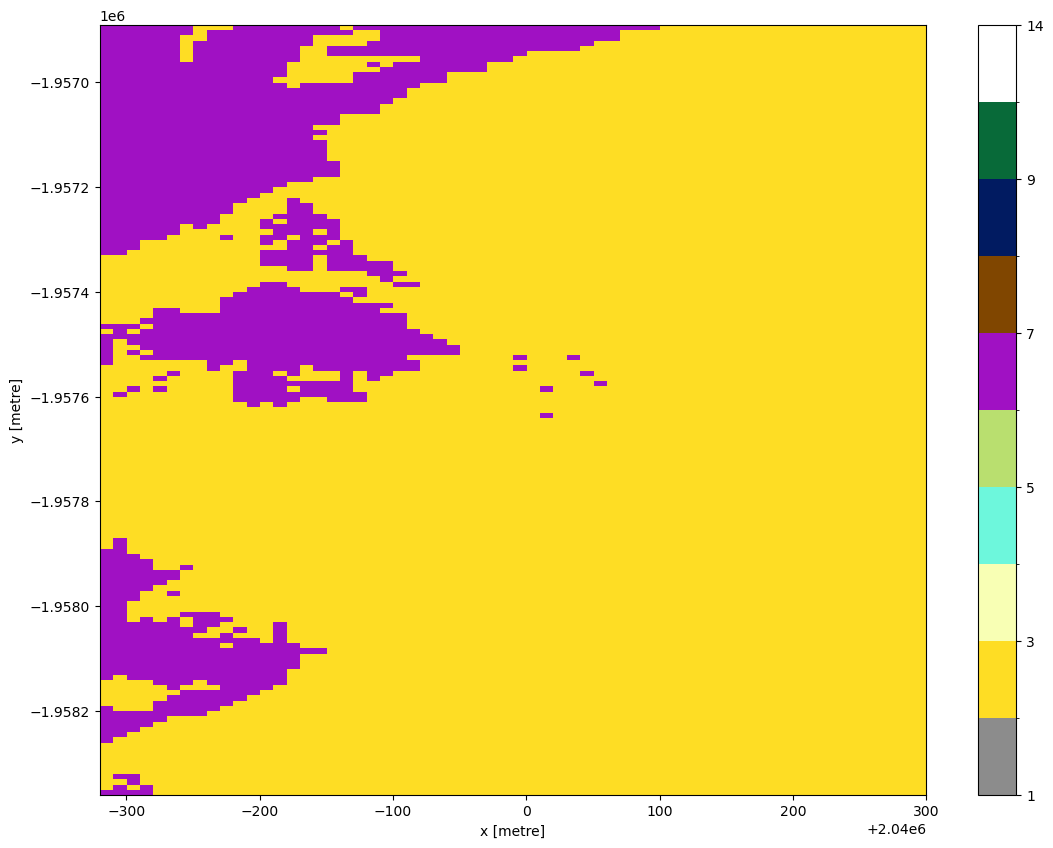

In [68]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [69]:
predicted_da.odc.explore()

In [70]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(all_masks)

In [71]:
predicted_da.odc.explore(cmap=c_map)

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [72]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(bg < 0.2)
predicted_da.odc.explore(cmap=c_map)

In [73]:
predicted_da.odc.write_cog(f"{version}.tiff", overwrite=True)

PosixPath('nm-utanglang-04-07-2025.tiff')